In [1]:
import os, sys
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [2]:
# context manager to suppress stdoutm for annoying long printouts
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
experiment = 'alexnet_trained_on_coco'
batch_size = 300

In [4]:
platform = 'paperspace' #@param ['colab', 'paperspace'] {allow-input: true}

if platform == 'jupyter_notebook':
    challenge_data_dir = '../data/algonauts_2023_challenge_data'
    exp_output_dir = f'../data/out/{experiment}'

if platform == 'paperspace':
    challenge_data_dir = '/storage/algonauts_2023_challenge_data'
    exp_output_dir = f'/notebooks/data/out/{experiment}'

## Functions not aligned with the current structuree

In [5]:
def train_pca(model, train_dataset):
    
    features = []
    for batch in train_dataset:
        # Extract features
        with HiddenPrints():
            ft = model.predict(batch)
        # Flatten the features
        ft = ft.reshape(ft.shape[0], -1)
        # Append to list
        features.append(ft)
    # Combine features from all batches
    features = np.vstack(features)
    n_components = 100
    print('Features shape: ', features.shape, ' PCA Components: ', n_components)
    # Fit PCA to combined features
    pca = PCA(n_components=n_components)
    pca.fit(features)
    # print('plot the explained variance')
    # plt.plot(pca.explained_variance_ratio_)
    # plt.show()
    # print('plot the cumulative explained variance')
    # plt.plot(np.cumsum(pca.explained_variance_ratio_))
    # plt.show()
    return pca

def extract_and_transform_features(dataset, model, pca):
    features = []
    for batch in dataset:
        with HiddenPrints():
            ft = model.predict(batch)
        # Flatten the features
        ft = ft.reshape(ft.shape[0], -1)
        # Fit PCA to batch of features
        ft = pca.transform(ft)
        features.append(ft)
    return np.vstack(features)

def load_datasets(dataset, transform_image):
    train_val_imgs_paths = [os.path.join(dataset.train_img_dir, img_name) for img_name in dataset.training_img_list]
    train_paths = [train_val_imgs_paths[i] for i in dataset.idxs_train]
    val_paths = [train_val_imgs_paths[i] for i in dataset.idxs_val]
    test_imgs_paths = [os.path.join(dataset.test_img_dir, img_name) for img_name in dataset.test_img_list]

    train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
    val_ds = tf.data.Dataset.from_tensor_slices(val_paths)
    test_ds = tf.data.Dataset.from_tensor_slices(test_imgs_paths)

    def load_image(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        return img
    
    def preprocess(ds):
        ds = ds.map(load_image)
        ds = ds.map(transform_image)
        return ds
    
    train_ds = preprocess(train_ds).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = preprocess(val_ds).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = preprocess(test_ds).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

def save_predictions(lh_fmri_test_pred, rh_fmri_test_pred, subject_submission_dir):
    lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
    rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

    np.save(os.path.join(subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
    np.save(os.path.join(subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)

## Specify model and appropriate image preprocessing steps
Define a function to load and return the model, printing its layers.
Due to memory constraints, we will delete the model from memory in each loop. Here we first load it, print its
nodes and delete it.

### Choose to load a pretrained model from keras.applications

In [ ]:
def load_model(layer_name=None):
    model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
    # Slice the model to extract features from a specific layer
    if layer_name is not None:
        model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return model

def transform_image(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image

### Or choose to load a model from file

In [6]:
model_filename = 'model.h5'

def load_model(layer_name=None):
    model = tf.keras.models.load_model(model_filename)
    # Slice the model to extract features from a specific layer
    if layer_name is not None:
        model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return model

def transform_image(image):
    image = tf.image.resize(image, (227, 227))
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    mean = [0.485, 0.456, 0.406]
    variance = [0.229, 0.224, 0.225]
    normalization_layer = Normalization(mean=mean, variance=variance)
    image = normalization_layer(image)
    return image

### Print the model layers

In [7]:
model = load_model()
print(*(layer.name for layer in model.layers), sep=' -> ')
del model

conv2d -> batch_normalization -> max_pooling2d -> conv2d_1 -> batch_normalization_1 -> max_pooling2d_1 -> conv2d_2 -> batch_normalization_2 -> conv2d_3 -> batch_normalization_3 -> conv2d_4 -> batch_normalization_4 -> max_pooling2d_2 -> flatten -> dense -> dropout -> dense_1 -> dropout_1 -> dense_2


## Select layers and subjects
Now let's define which layer(s) we will pick from, and which subject(s) to process

In [7]:
layers = ['max_pooling2d_1']
subjects = [
    1, 
    # 2, 3, 4, 5, 6, 7, 8
    ]


## Run pipeline

Running for layer max_pooling2d_1
Running for subject 1
Training images: 9841
Test images: 159
LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)
Training images: 9841
Test images: 159
Training stimulus images: 8856

Validation stimulus images: 985

Test stimulus images: 159
Loading datasets...
Datasets loaded
Training PCA...
Features shape:  (8856, 43264)  PCA Components:  100
PCA over
Extracting and transforming features...
Features extracted and transformed
Fitting regression...
Regression fitted
Predicting fMRI data...
fMRI data predicted
Calculating correlations...


100%|██████████| 20544/20544 [00:02<00:00, 8314.84it/s]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Correlations calculated
output dir:  /notebooks/data/out/alexnet_trained_on_coco
Layer: max_pooling2d_1 Subject: 1

LH Correlation: 0.3248972025465593 RH Correlation: 0.32755516492237513



LH median roi correlation: ['V1v: 0.5588656489912602', 'V1d: 0.5806036224897868', 'V2v: 0.4831071547804415', 'V2d: 0.47987157652643214', 'V3v: 0.45820250576032623', 'V3d: 0.4621128774575143', 'hV4: 0.36248482164792944', 'EBA: 0.3264131174453112', 'FBA-1: 0.28370353027257633', 'FBA-2: nan', 'mTL-bodies: nan', 'OFA: 0.3296447992275998', 'FFA-1: 0.34724751634024853', 'FFA-2: nan', 'mTL-faces: nan', 'aTL-faces: nan', 'OPA: 0.3368286697294823', 'PPA: 0.3152436195757676', 'RSC: 0.40267095702051275', 'OWFA: 0.3422805837320571', 'VWFA-1: 0.24905853146496093', 'VWFA-2: 0.1796562486308054', 'mfs-words: 0.18258804750148983', 'mTL-words: nan', 'early: 0.45191954361615166', 'midventral: 0.3765235443607076', 'midlateral: 0.3323320190820965', 'midparietal: 0.3731465155738021', 'ventral: 0.26223956417171984', 'late

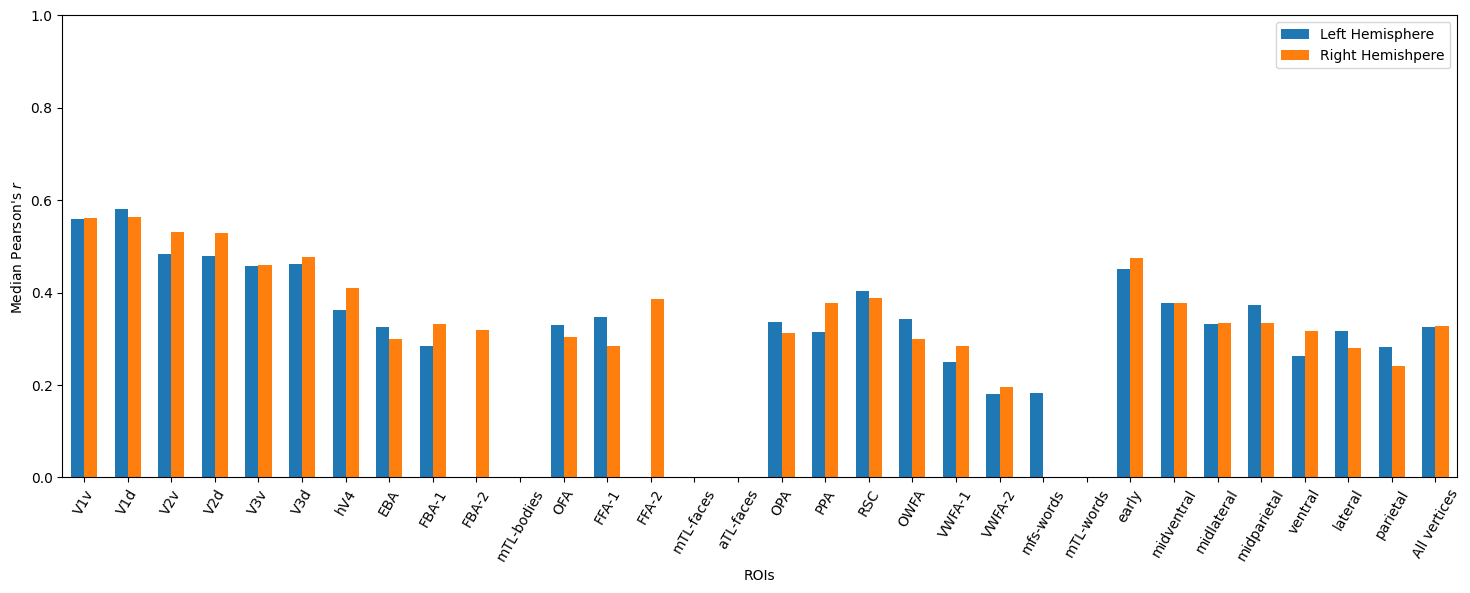

Running for subject 2
Training images: 9841
Test images: 159
LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)
Training images: 9841
Test images: 159
Training stimulus images: 8856

Validation stimulus images: 985

Test stimulus images: 159
Loading datasets...
Datasets loaded
Training PCA...
Features shape:  (8856, 43264)  PCA Components:  100
PCA over
Extracting and transforming features...
Features extracted and transformed
Fitting regression...
Regression fitted
Predicting fMRI data...
fMRI data predicted
Calculating correlations...


100%|██████████| 20544/20544 [00:02<00:00, 8335.21it/s]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Correlations calculated
output dir:  /notebooks/data/out/alexnet_trained_on_coco
Layer: max_pooling2d_1 Subject: 2

LH Correlation: 0.35630169327374445 RH Correlation: 0.3484298491774274



LH median roi correlation: ['V1v: 0.48565616876203915', 'V1d: 0.5897229416966622', 'V2v: 0.4692968073935833', 'V2d: 0.4479938213693392', 'V3v: 0.377600739548543', 'V3d: 0.4795438743718131', 'hV4: 0.46768392329147246', 'EBA: 0.3463770201551345', 'FBA-1: nan', 'FBA-2: 0.37255747622087776', 'mTL-bodies: nan', 'OFA: 0.38423699837343417', 'FFA-1: 0.33630611952812445', 'FFA-2: 0.30389472735134637', 'mTL-faces: nan', 'aTL-faces: nan', 'OPA: 0.34996425079901905', 'PPA: 0.4678699171221772', 'RSC: 0.49704715950871065', 'OWFA: 0.3307783452476373', 'VWFA-1: 0.30662437450984487', 'VWFA-2: 0.23865625040294638', 'mfs-words: 0.26357235844010957', 'mTL-words: nan', 'early: 0.41921074894626614', 'midventral: 0.37684939936286704', 'midlateral: 0.39031867162952183', 'midparietal: 0.31590484970880917', 'ventral: 0.37165

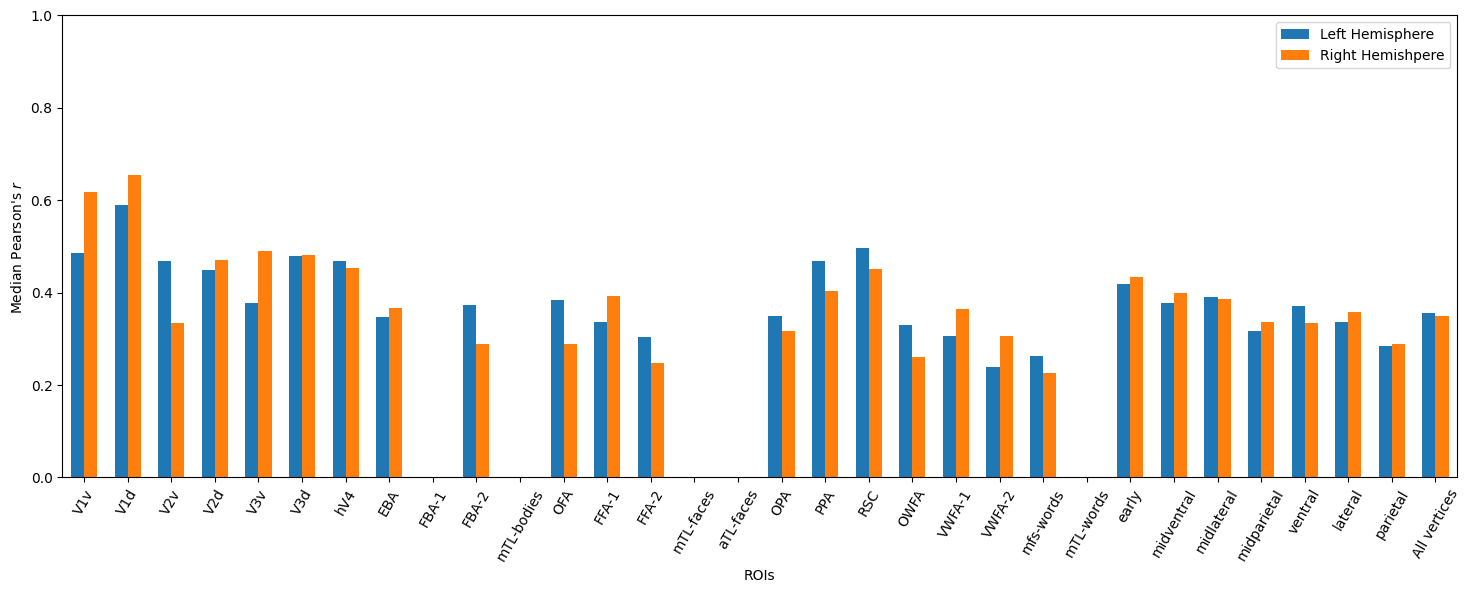

Running for subject 3
Training images: 9082
Test images: 293
LH training fMRI data shape:
(9082, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9082, 20544)
(Training stimulus images × RH vertices)
Training images: 9082
Test images: 293
Training stimulus images: 8173

Validation stimulus images: 909

Test stimulus images: 293
Loading datasets...
Datasets loaded
Training PCA...
Features shape:  (8173, 43264)  PCA Components:  100
PCA over
Extracting and transforming features...
Features extracted and transformed
Fitting regression...
Regression fitted
Predicting fMRI data...
fMRI data predicted
Calculating correlations...


100%|██████████| 20544/20544 [00:02<00:00, 7158.68it/s]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Correlations calculated
output dir:  /notebooks/data/out/alexnet_trained_on_coco
Layer: max_pooling2d_1 Subject: 3

LH Correlation: 0.2764900696018677 RH Correlation: 0.2787225227132114



LH median roi correlation: ['V1v: 0.5389833395278164', 'V1d: 0.4989355088402242', 'V2v: 0.4890631305936285', 'V2d: 0.3903648876723865', 'V3v: 0.4124922878575461', 'V3d: 0.3178761163924269', 'hV4: 0.33469718882488597', 'EBA: 0.2762089985971588', 'FBA-1: 0.18685582743192725', 'FBA-2: 0.2544802355012833', 'mTL-bodies: nan', 'OFA: 0.3184601946468367', 'FFA-1: 0.2945829600724821', 'FFA-2: 0.22396262916037193', 'mTL-faces: nan', 'aTL-faces: nan', 'OPA: 0.2927253603402541', 'PPA: 0.3038319873636009', 'RSC: 0.28559861343203496', 'OWFA: 0.3295325879563508', 'VWFA-1: 0.18647466598064266', 'VWFA-2: 0.12017237039363288', 'mfs-words: 0.23444985956393835', 'mTL-words: nan', 'early: 0.3383944157248211', 'midventral: 0.39288802576784704', 'midlateral: 0.29793906957353905', 'midparietal: 0.25179960158255427', 'ventra

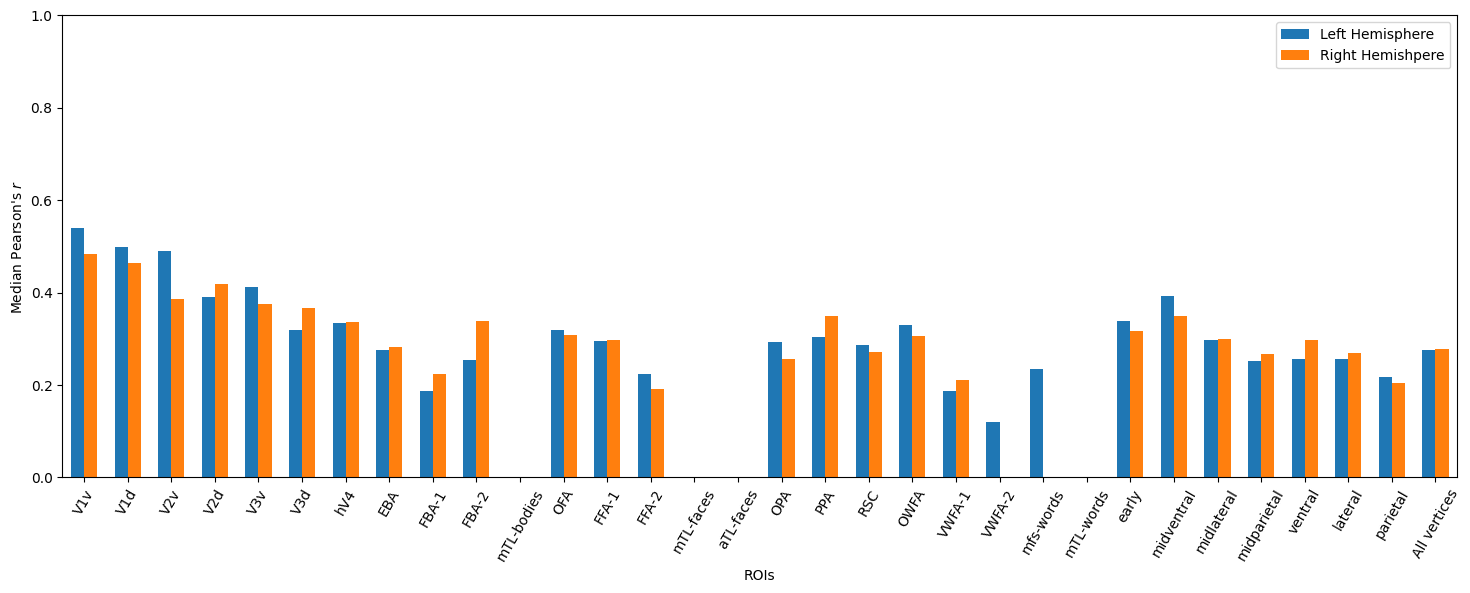

Running for subject 4
Training images: 8779
Test images: 395
LH training fMRI data shape:
(8779, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(8779, 20544)
(Training stimulus images × RH vertices)
Training images: 8779
Test images: 395
Training stimulus images: 7901

Validation stimulus images: 878

Test stimulus images: 395
Loading datasets...
Datasets loaded
Training PCA...
Features shape:  (7901, 43264)  PCA Components:  100
PCA over
Extracting and transforming features...
Features extracted and transformed
Fitting regression...
Regression fitted
Predicting fMRI data...
fMRI data predicted
Calculating correlations...


100%|██████████| 20544/20544 [00:02<00:00, 7095.35it/s]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Correlations calculated
output dir:  /notebooks/data/out/alexnet_trained_on_coco
Layer: max_pooling2d_1 Subject: 4

LH Correlation: 0.2342368361252221 RH Correlation: 0.2787235032933255



LH median roi correlation: ['V1v: 0.49215902736648237', 'V1d: 0.43729795130735916', 'V2v: 0.4363695102078626', 'V2d: 0.42707003816310596', 'V3v: 0.3629394587404783', 'V3d: 0.31794104400214906', 'hV4: 0.26611177720032947', 'EBA: 0.21293892815912221', 'FBA-1: nan', 'FBA-2: 0.18057699135397798', 'mTL-bodies: nan', 'OFA: 0.27385375920876043', 'FFA-1: 0.266046388083019', 'FFA-2: 0.22452175951137557', 'mTL-faces: nan', 'aTL-faces: nan', 'OPA: 0.24237741035510038', 'PPA: 0.3191997142986687', 'RSC: 0.35238129387055583', 'OWFA: 0.23377356306296454', 'VWFA-1: 0.16221737762528', 'VWFA-2: 0.1938576601678001', 'mfs-words: 0.20881774242123152', 'mTL-words: nan', 'early: 0.31226501751533675', 'midventral: 0.271859254398269', 'midlateral: 0.21094021127828966', 'midparietal: 0.2560686687244365', 'ventral: 0.243634912

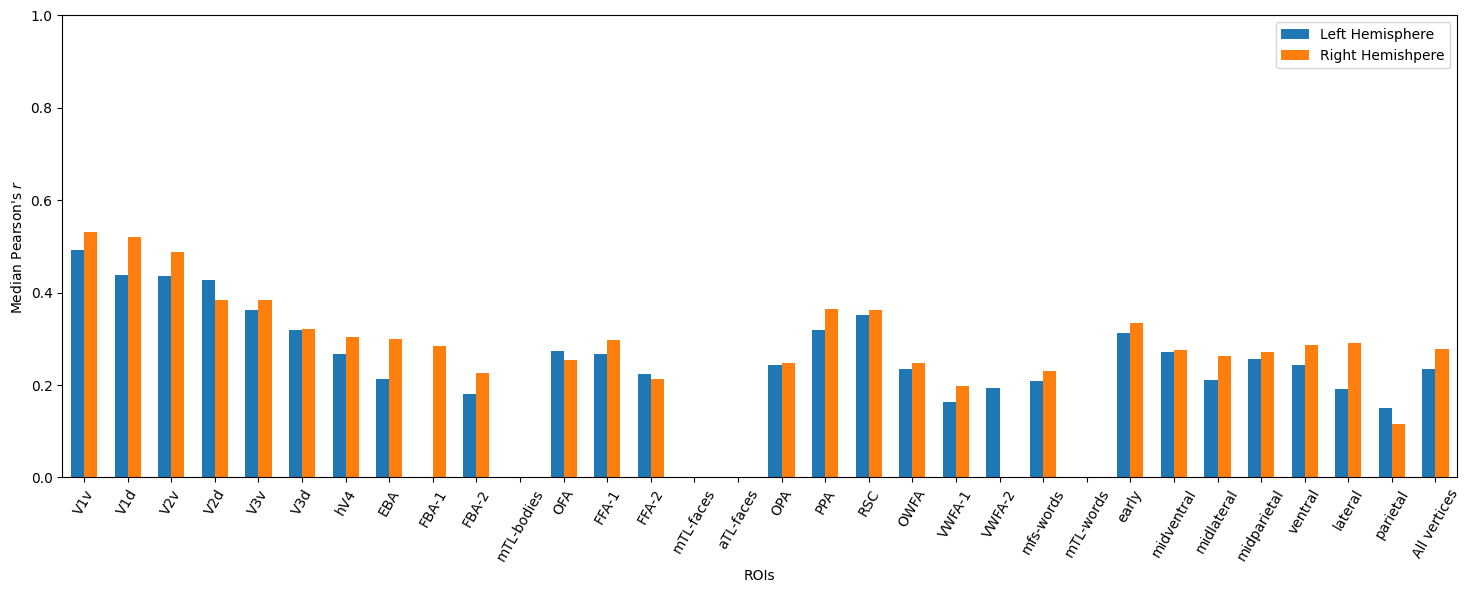

Running for subject 5
Training images: 9841
Test images: 159
LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)
Training images: 9841
Test images: 159
Training stimulus images: 8856

Validation stimulus images: 985

Test stimulus images: 159
Loading datasets...
Datasets loaded
Training PCA...
Features shape:  (8856, 43264)  PCA Components:  100
PCA over
Extracting and transforming features...
Features extracted and transformed
Fitting regression...
Regression fitted
Predicting fMRI data...
fMRI data predicted
Calculating correlations...


100%|██████████| 20544/20544 [00:02<00:00, 7342.07it/s]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Correlations calculated
output dir:  /notebooks/data/out/alexnet_trained_on_coco
Layer: max_pooling2d_1 Subject: 5

LH Correlation: 0.35467289028748017 RH Correlation: 0.340883870966332



LH median roi correlation: ['V1v: 0.5040831458408093', 'V1d: 0.5078638741107515', 'V2v: 0.5250222807976102', 'V2d: 0.3973106614759897', 'V3v: 0.40660443081735376', 'V3d: 0.3623826167701288', 'hV4: 0.36346512407437614', 'EBA: 0.3158309946705253', 'FBA-1: 0.31575850271428957', 'FBA-2: 0.3752888252787625', 'mTL-bodies: nan', 'OFA: 0.3350941939346644', 'FFA-1: 0.35900974834914484', 'FFA-2: 0.391114616988888', 'mTL-faces: nan', 'aTL-faces: nan', 'OPA: 0.38692424547885385', 'PPA: 0.4128880040837698', 'RSC: 0.4082499380610807', 'OWFA: 0.3154360104369527', 'VWFA-1: 0.3245819437004057', 'VWFA-2: 0.3022040164920031', 'mfs-words: 0.3833814927500015', 'mTL-words: nan', 'early: 0.4152417402253912', 'midventral: 0.3731978836656189', 'midlateral: 0.26486420902308916', 'midparietal: 0.3850366632018005', 'ventral: 0.

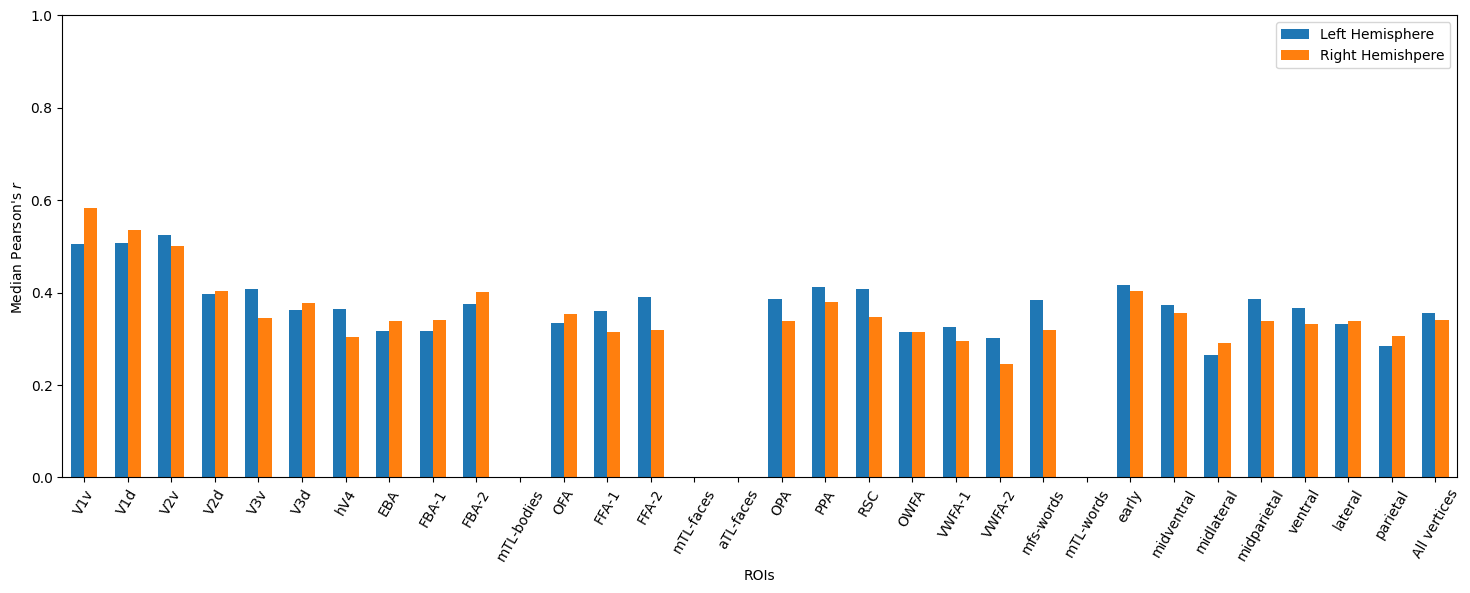

Running for subject 6
Training images: 9082
Test images: 293
LH training fMRI data shape:
(9082, 18978)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9082, 20220)
(Training stimulus images × RH vertices)
Training images: 9082
Test images: 293
Training stimulus images: 8173

Validation stimulus images: 909

Test stimulus images: 293
Loading datasets...
Datasets loaded
Training PCA...
Features shape:  (8173, 43264)  PCA Components:  100
PCA over
Extracting and transforming features...
Features extracted and transformed
Fitting regression...
Regression fitted
Predicting fMRI data...
fMRI data predicted
Calculating correlations...


100%|██████████| 20220/20220 [00:02<00:00, 6905.90it/s]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Correlations calculated
output dir:  /notebooks/data/out/alexnet_trained_on_coco
Layer: max_pooling2d_1 Subject: 6

LH Correlation: 0.2178724186497601 RH Correlation: 0.2501834147636179



LH median roi correlation: ['V1v: 0.48303205770243024', 'V1d: 0.41909739512756183', 'V2v: 0.4745762387279263', 'V2d: 0.3770546535692588', 'V3v: 0.3620777981666953', 'V3d: 0.27710949658533957', 'hV4: 0.3090800780884293', 'EBA: 0.2109308796663217', 'FBA-1: 0.26120363855468276', 'FBA-2: 0.09966439778523672', 'mTL-bodies: nan', 'OFA: 0.2721890257942145', 'FFA-1: 0.2869166723447026', 'FFA-2: 0.13333191226806843', 'mTL-faces: nan', 'aTL-faces: nan', 'OPA: 0.24827527465001775', 'PPA: 0.2614350066705367', 'RSC: 0.21278378754079097', 'OWFA: 0.22353868289924378', 'VWFA-1: 0.18636509779237342', 'VWFA-2: 0.12019639634121082', 'mfs-words: 0.2119856678170907', 'mTL-words: -0.002672802716472448', 'early: 0.3131796487961769', 'midventral: 0.285756898987346', 'midlateral: 0.25014303178795205', 'midparietal: 0.2146447

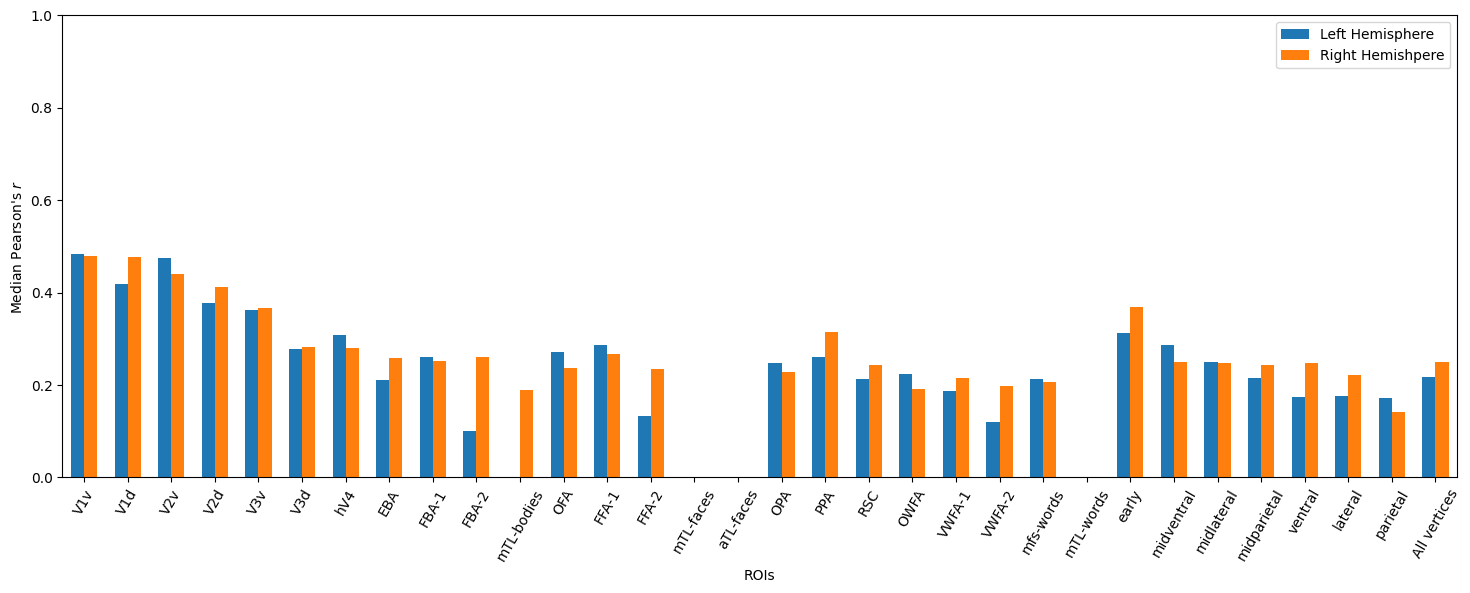

Running for subject 7
Training images: 9841
Test images: 159
LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)
Training images: 9841
Test images: 159
Training stimulus images: 8856

Validation stimulus images: 985

Test stimulus images: 159
Loading datasets...
Datasets loaded
Training PCA...
Features shape:  (8856, 43264)  PCA Components:  100
PCA over
Extracting and transforming features...
Features extracted and transformed
Fitting regression...
Regression fitted
Predicting fMRI data...
fMRI data predicted
Calculating correlations...


100%|██████████| 20544/20544 [00:02<00:00, 8135.15it/s]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Correlations calculated
output dir:  /notebooks/data/out/alexnet_trained_on_coco
Layer: max_pooling2d_1 Subject: 7

LH Correlation: 0.26425964813403696 RH Correlation: 0.26381289089731275



LH median roi correlation: ['V1v: 0.4038014653756081', 'V1d: 0.44432892967792936', 'V2v: 0.4746070672966154', 'V2d: 0.3664038708166319', 'V3v: 0.42179021079945944', 'V3d: 0.2989078910439147', 'hV4: 0.3271496750153412', 'EBA: 0.26953384026231963', 'FBA-1: nan', 'FBA-2: 0.24406886436997044', 'mTL-bodies: nan', 'OFA: 0.2849070491653203', 'FFA-1: 0.2531345850751522', 'FFA-2: 0.15473616830059694', 'mTL-faces: nan', 'aTL-faces: nan', 'OPA: 0.2927771450487315', 'PPA: 0.32763800454728376', 'RSC: 0.1891295872100564', 'OWFA: 0.23832741133429952', 'VWFA-1: 0.2466218939827652', 'VWFA-2: 0.2178016147773166', 'mfs-words: 0.211127236330507', 'mTL-words: nan', 'early: 0.3268935539486782', 'midventral: 0.3422248801920105', 'midlateral: 0.21139268699068056', 'midparietal: 0.29565856926107936', 'ventral: 0.2569474370

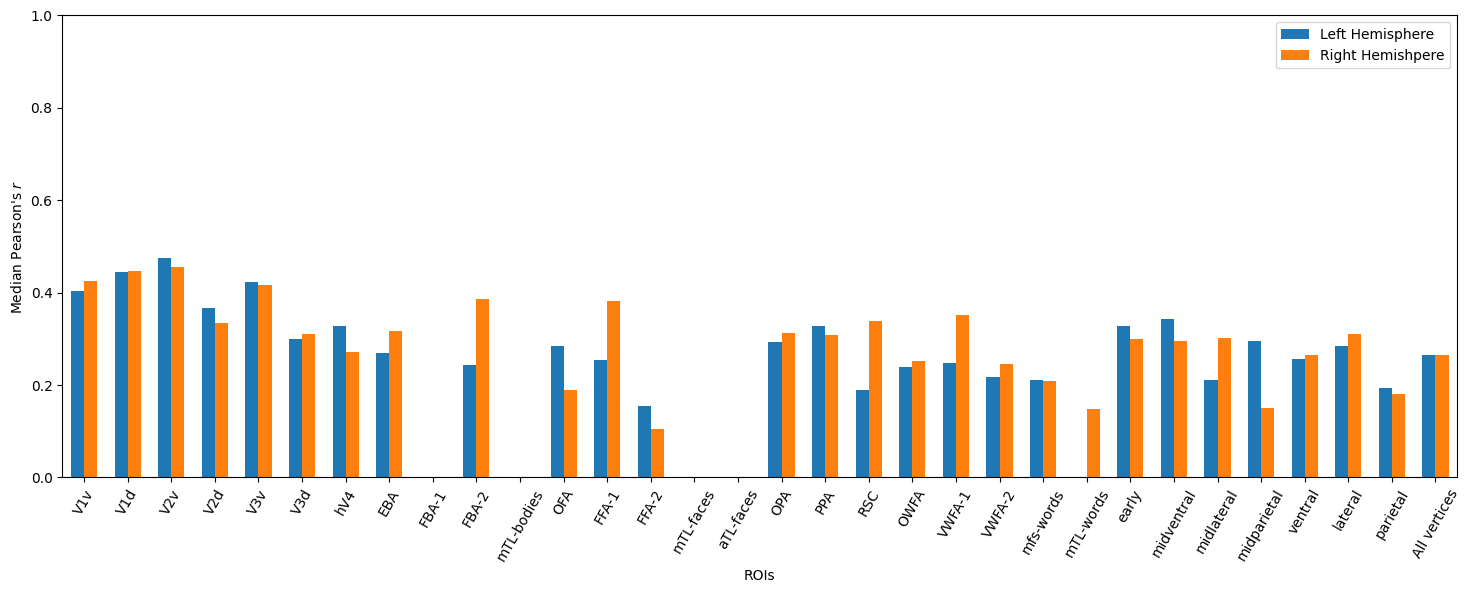

Running for subject 8
Training images: 8779
Test images: 395
LH training fMRI data shape:
(8779, 18981)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(8779, 20530)
(Training stimulus images × RH vertices)
Training images: 8779
Test images: 395
Training stimulus images: 7901

Validation stimulus images: 878

Test stimulus images: 395
Loading datasets...
Datasets loaded
Training PCA...
Features shape:  (7901, 43264)  PCA Components:  100
PCA over
Extracting and transforming features...
Features extracted and transformed
Fitting regression...
Regression fitted
Predicting fMRI data...
fMRI data predicted
Calculating correlations...


100%|██████████| 20530/20530 [00:02<00:00, 8230.07it/s]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Correlations calculated
output dir:  /notebooks/data/out/alexnet_trained_on_coco
Layer: max_pooling2d_1 Subject: 8

LH Correlation: 0.17995622513784007 RH Correlation: 0.1877504653979556



LH median roi correlation: ['V1v: 0.43053058820714296', 'V1d: 0.46591320558552096', 'V2v: 0.38374745586266357', 'V2d: 0.2744780271740817', 'V3v: 0.33423255528067974', 'V3d: 0.2071804431346376', 'hV4: 0.31144223162829043', 'EBA: 0.18599847510950757', 'FBA-1: 0.14745137617102672', 'FBA-2: 0.2287101812477952', 'mTL-bodies: nan', 'OFA: 0.2138166138461474', 'FFA-1: 0.19109856762446722', 'FFA-2: 0.17943713214514334', 'mTL-faces: nan', 'aTL-faces: nan', 'OPA: 0.20130651718933992', 'PPA: 0.2436693648158573', 'RSC: 0.2030325482326375', 'OWFA: 0.19103496565333375', 'VWFA-1: 0.11777447848304559', 'VWFA-2: 0.0537672252918442', 'mfs-words: 0.11182463942814866', 'mTL-words: nan', 'early: 0.22205608485364497', 'midventral: 0.2745113923595155', 'midlateral: 0.2163490538969698', 'midparietal: 0.19233841537968607', '

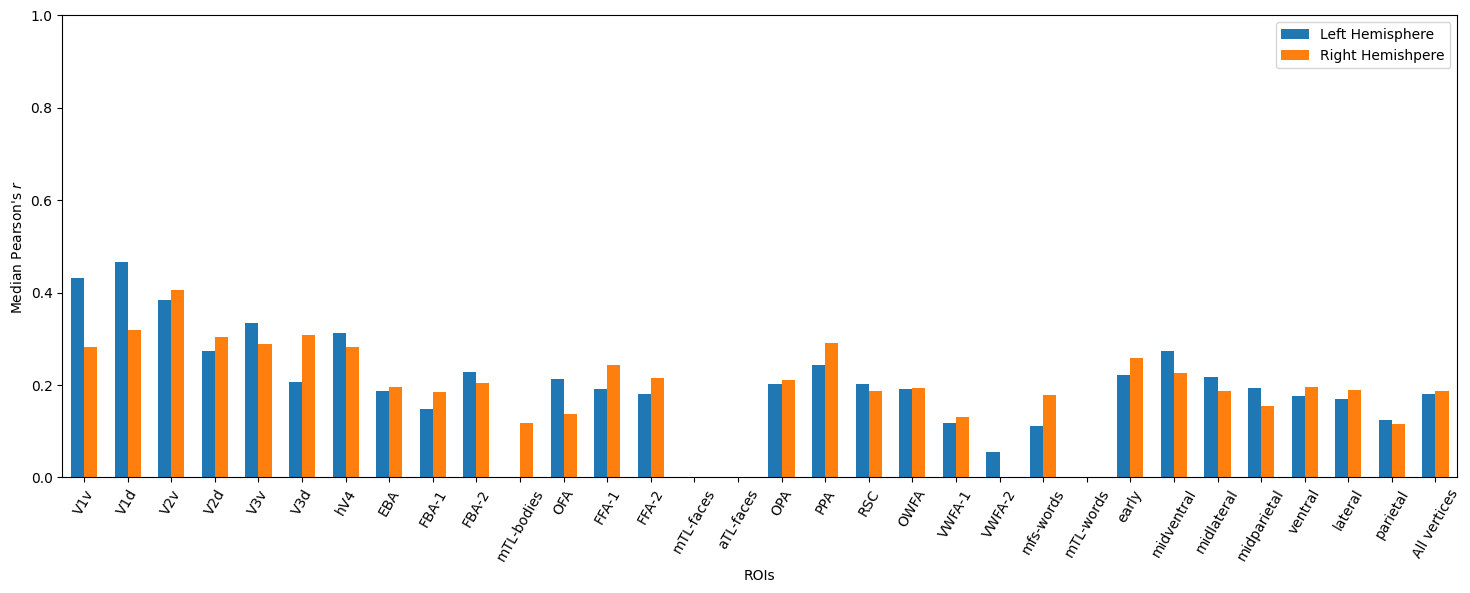

In [8]:
from src.algonauts.evaluators import correlations as corr
from src.algonauts.data_processors.nsd_dataset import NSDDataset

for layer_name in layers:
    print(f'Running for layer {layer_name}')
    for subj in subjects:
        print(f'Running for subject {subj}')

        # Set data directories based on parameters
        output_dir = f'{exp_output_dir}/{layer_name}'
        dataset = NSDDataset(challenge_data_dir, output_dir, subj)

        print('Loading datasets...')
        train_ds, val_ds, test_ds = load_datasets(dataset, transform_image)
        print('Datasets loaded')

        # Load model for the iteration
        model = load_model(layer_name)
        
        # Train PCA
        print('Training PCA...')
        pca = train_pca(model, train_ds)
        print('PCA over')

        # Extract and transform features
        print('Extracting and transforming features...')
        train_features = extract_and_transform_features(train_ds, model, pca)
        val_features = extract_and_transform_features(val_ds, model, pca)
        test_features = extract_and_transform_features(test_ds, model, pca)
        print('Features extracted and transformed')

        # Delete model to free up memory
        del model, pca

        # Fit regression
        print('Fitting regression...')
        reg_lh = LinearRegression().fit(train_features, dataset.lh_fmri_train)
        reg_rh = LinearRegression().fit(train_features, dataset.rh_fmri_train)
        print('Regression fitted')
        
        # Use fitted linear regressions to predict the validation and test fMRI data
        print('Predicting fMRI data...')
        lh_fmri_val_pred = reg_lh.predict(val_features)
        lh_fmri_test_pred = reg_lh.predict(test_features)
        rh_fmri_val_pred = reg_rh.predict(val_features)
        rh_fmri_test_pred = reg_rh.predict(test_features)
        print('fMRI data predicted')
        # Calculate correlations for each hemispher
        print('Calculating correlations...')
        lh_correlation = corr.calculate_correlation(lh_fmri_val_pred, dataset.lh_fmri_val)
        rh_correlation = corr.calculate_correlation(rh_fmri_val_pred, dataset.rh_fmri_val)  
        print('Correlations calculated')
    
        corr.plot_and_write_correlations(dataset, lh_correlation, rh_correlation, exp_output_dir, layer_name, subj)
        # Save test predictions
        np.save(os.path.join(dataset.subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
        np.save(os.path.join(dataset.subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)